In [78]:
from math import sqrt
from itertools import permutations
from typing import Any
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [79]:
class Tsp:

    def __init__(self, num_cities: int, seed: Any = None) -> None:
        if seed is None:
            seed = num_cities
        self._num_cities = num_cities
        self._graph = nx.DiGraph()
        np.random.seed(seed)
        for c in range(num_cities):
            self._graph.add_node(c, pos=(np.random.random(), np.random.random()))

    def distance(self, n1, n2) -> int:
        pos1 = self._graph.nodes[n1]['pos']
        pos2 = self._graph.nodes[n2]['pos']
        return round(1_000_000 / self._num_cities * sqrt((pos1[0] - pos2[0])**2 +
                                                         (pos1[1] - pos2[1])**2))

    def evaluate_solution(self, solution: np.array) -> float:
        total_cost = 0
        tmp = solution.tolist() + [solution[0]]
        for n1, n2 in (tmp[i:i + 2] for i in range(len(tmp) - 1)):
            total_cost += self.distance(n1, n2)
        return total_cost

    def plot(self, path: np.array = None) -> None:
        if path is not None:
            self._graph.remove_edges_from(list(self._graph.edges))
            tmp = path.tolist() + [path[0]]
            for n1, n2 in (tmp[i:i + 2] for i in range(len(tmp) - 1)):
                self._graph.add_edge(n1, n2)
        plt.figure(figsize=(12, 5))
        nx.draw(self._graph,
                pos=nx.get_node_attributes(self._graph, 'pos'),
                with_labels=True,
                node_color='pink')
        if path is not None:
            plt.title(f"Current path: {self.evaluate_solution(path):,}")
        plt.show()

    @property
    def graph(self) -> nx.digraph:
        return self._graph

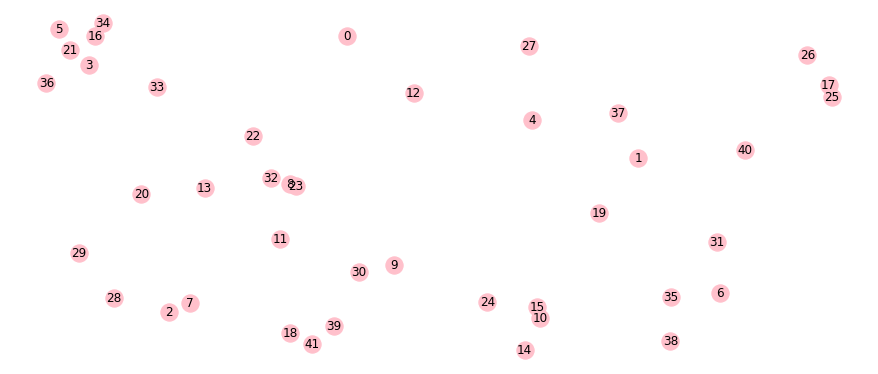

In [411]:
NUM_CITIES = 42

problem = Tsp(NUM_CITIES)
problem.plot()

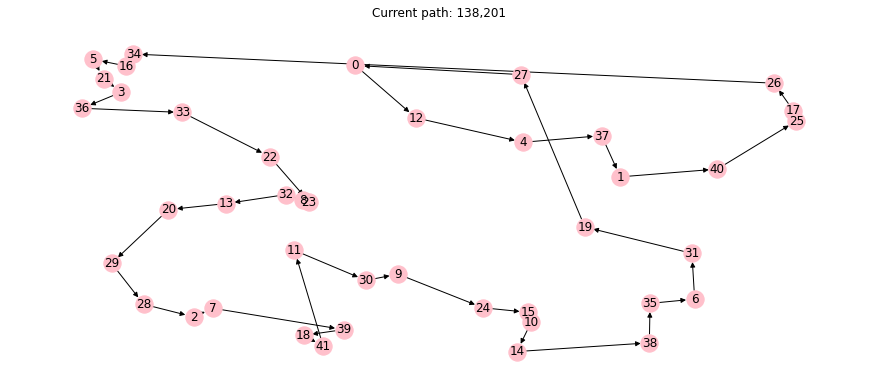

In [412]:
G = nx.Graph()
G.add_nodes_from(problem.graph.nodes())
for n1, n2, _ in sorted([(n1, n2, problem.distance(n1, n2)) for n1, n2 in permutations(problem.graph.nodes(), 2)], key=lambda t: t[2]):
    if len(G.edges(n1)) < 2 and len(G.edges(n2)) < 2:
        G.add_edge(n1, n2)
        try:
            nx.find_cycle(G)
            G.remove_edge(n1, n2)
        except:
            pass

G.add_edge(*[n for n in G if len(G.edges(n))<2])
solution = np.array([0] + [n[0] for n in nx.dfs_successors(G, 0).values()])
problem.plot(solution)

In [357]:
#Swap mutation
def tweak(solution: np.array, *, pm: float = 1/NUM_CITIES) -> np.array:
    new_solution = solution.copy()
    p = None
    while p is None or p < pm:
        i1 = np.random.randint(0, NUM_CITIES)
        i2 = np.random.randint(0, NUM_CITIES)
        temp = new_solution[i1]
        new_solution[i1] = new_solution[i2]
        new_solution[i2] = temp
        p = np.random.random()
    return new_solution

#Scramble mutation - not big changes with respect to swap mutation
def tweak2(solution: np.array, *, pm: float = 1/NUM_CITIES) -> np.array:
    new_solution = solution.copy()
    p = None
    while p is None or p < pm:
        i1 = np.random.randint(0, NUM_CITIES)
        i2 = np.random.randint(0, NUM_CITIES)
        if i1 > i2:
          temp = i1
          i1 = i2
          i2 = temp
        if i2 - i1 >= 2:
          temp = new_solution[i1+1:i2].copy()
          new_solution[i1+1] = new_solution[i2]
          new_solution[i1+2:i2+1] = temp
        p = np.random.random()
    return new_solution

#Cycle crossover - Not working at all
def tweak3(solution1, solution2, pm):
    new_solution = np.array([-1 for _ in range(NUM_CITIES)])
    p = None
    i1 = np.random.randint(0, NUM_CITIES)
    i2 = np.random.randint(0, NUM_CITIES)
    if i1 > i2:
      temp = i1
      i1 = i2
      i2 = temp
    if i2 - i1 >= 1:
      new_solution[i1+1:i2] = solution1[i1+1:i2].copy()
      index = 0
      for x in solution2:
        if x not in new_solution:
          while new_solution[index] != -1 and index < NUM_CITIES:
            index+=1
          if index >= NUM_CITIES: 
            break
          new_solution[index] = x
          index+=1
    else:
      new_solution = solution1.copy()
    return new_solution

In [370]:
#Tournament is not working very well
def tournament_selection(g, n=3):
  x = np.arange(len(g), dtype = int)
  np.random.shuffle(x)
  i = 0
  parents = []
  while len(x) > n:
    l = []
    for t in x[0:n]:
      l.append(g[t])
    ls = sorted(l, key = lambda x : problem.evaluate_solution(x))
    parents.append(ls[0])
    x = x[n:]
  l=[]
  while len(x) > 0:
    l.append(g[0])
    if len(x) == 1:
      x = []
    else:
      x = x[1:]
  ls = sorted(l, key = lambda x: problem.evaluate_solution(x))
  parents.append(ls[0])
  return parents

#Choosing the n best solutions as parents seems to work
def best_parents(g, gs, n):
  return [sol for sol, _ in sorted(zip(g, gs), key = lambda x : x[1])][0:n]


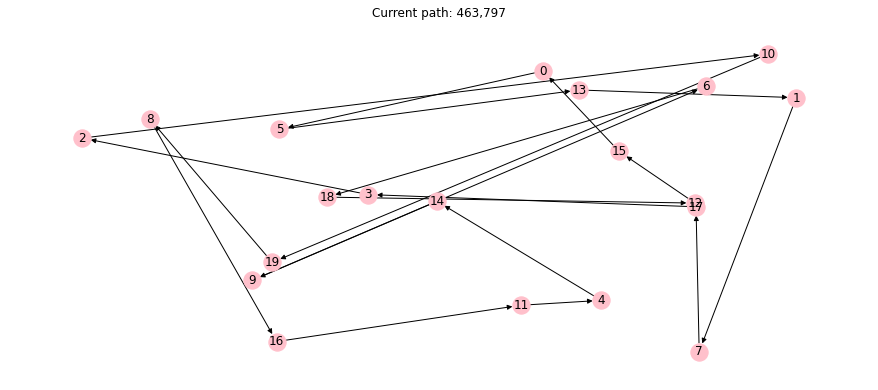

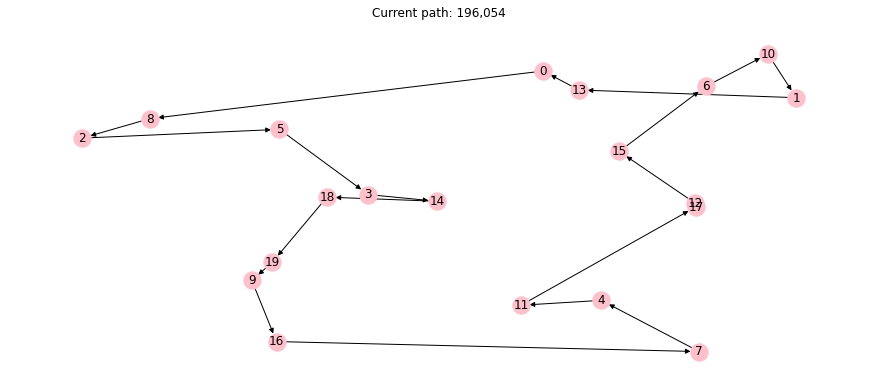

In [410]:
STEADY_STATE = 1000

solution = np.array(range(NUM_CITIES))
np.random.shuffle(solution)
solution_cost = problem.evaluate_solution(solution)
problem.plot(solution)

history = [(0, solution_cost)]
steady_state = 0
step = 0
population = NUM_CITIES
generation = np.array([tweak(solution, pm=1/population) for _ in range(population)])
generation_costs = np.array([problem.evaluate_solution(generation[x]) for x in range(population)])
while steady_state < STEADY_STATE:
    step += 1
    steady_state += 1
    parents = best_parents(generation, generation_costs, max(2, int(NUM_CITIES/20)))
    generation = [tweak(parents[np.random.randint(len(parents))], pm=0.25 + 1/population) for _ in range(population)]
    generation_costs = [problem.evaluate_solution(generation[x]) for x in range(population)]
    for sol, cost in sorted(zip(generation, generation_costs), key = lambda x : x[1]):
      if cost < solution_cost:
        solution = sol.copy()
        solution_cost = cost
        history.append((step, solution_cost))
        steady_state = 0
      break
problem.plot(solution)